# 0. Imports

## 0.1. Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
import scikitplot as skplt
import numpy as np
import pickle
from flask import Flask, request
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

from boruta import BorutaPy

## 0.2. Helper Functions

In [2]:
# Save intermediate dataset
def save_interim(dataframe, file_name):
   dataframe.to_csv('../data/interim/'+file_name+'.zip', index=False, compression= 'zip')

# Load intermediate dataset
def load_interim(file_name):
   return pd.read_csv('../data/interim/'+file_name, compression='zip')

## 0.2. Loading Dataset

In [3]:
df_raw = pd.read_csv('/home/ezequiel/Documentos/Comunidade_DS/health_insurance_cross_sell/data/raw/train.csv')
df1 = df_raw.copy()

In [4]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df1.columns = df1.columns.str.lower()

In [6]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

# 1. Data Description

## 1.1. Data Dimension

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.2. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.4. Data Description

### 1.4.1. Categorical variables

In [10]:
cat_attributes = df1.select_dtypes(include='object')
cat_attributes.value_counts()

gender  vehicle_age  vehicle_damage
Male    1-2 Year     Yes               79533
Female  < 1 Year     No                66047
Male    < 1 Year     No                50543
Female  1-2 Year     Yes               48692
Male    1-2 Year     No                42791
Female  1-2 Year     No                29300
        < 1 Year     Yes               25274
Male    < 1 Year     Yes               22922
        > 2 Years    Yes               10293
Female  > 2 Years    Yes                5699
                     No                    8
Male    > 2 Years    No                    7
Name: count, dtype: int64

### 1.4.2. Numerical variables

In [11]:
num_attributes = df1.select_dtypes(exclude='object')
df_describe = num_attributes.describe().T
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe['skewness'] = num_attributes.skew()

In [12]:
df_describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,-1.200000,9.443274e-16
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00


In [13]:
save_interim(df1, 'train_df1.csv')

# 2. Feature Engeneering

In [14]:
df1['vehicle_age'] = df1['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else
                                              'below_1_year')

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [15]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


In [16]:
save_interim(df1, 'train_df2.csv')

# 3. Data Filtering

# 4. Exploration Data Analysis (EDA)

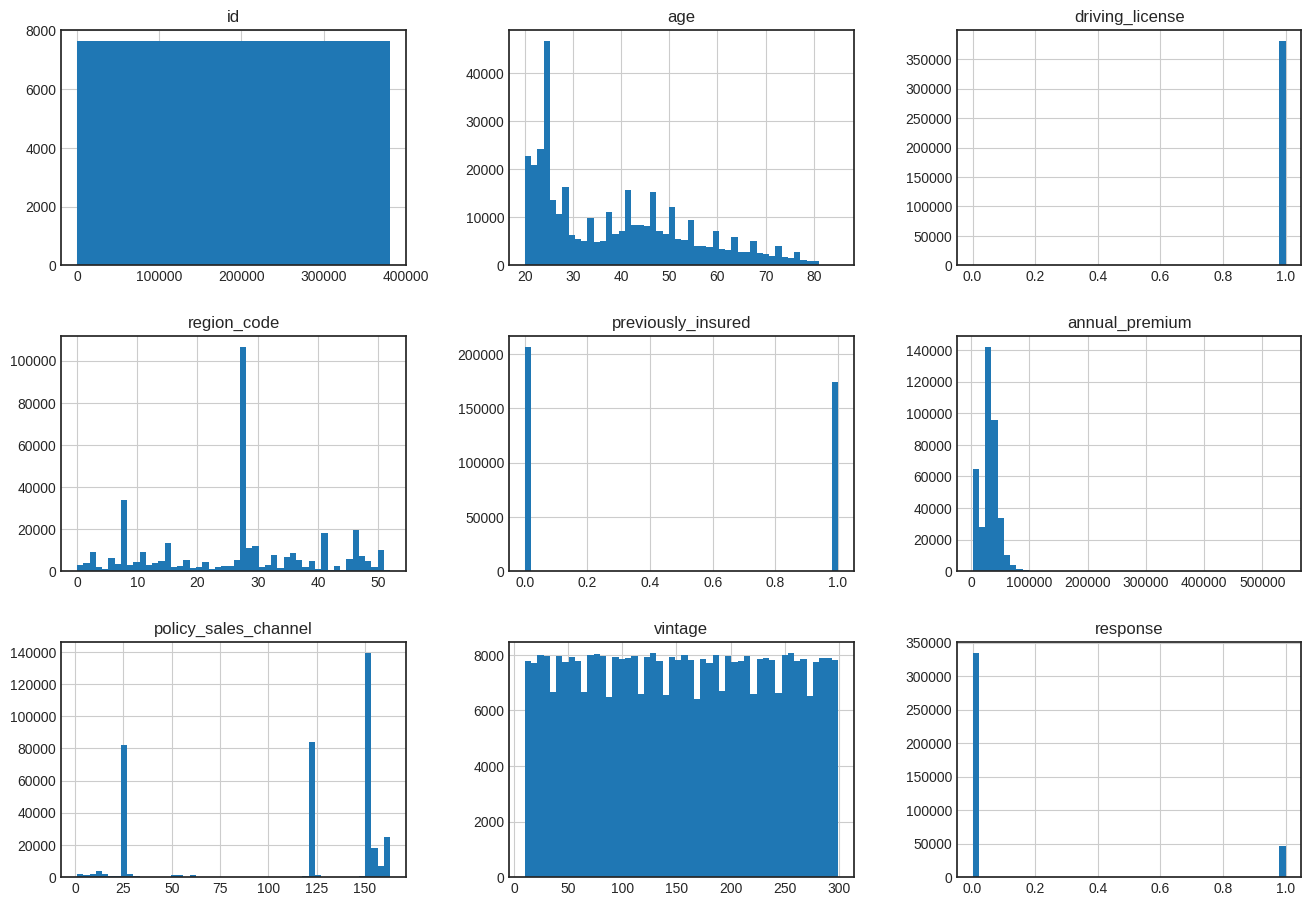

In [17]:
num_attributes.hist(bins=50, figsize=(16,11));

In [18]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 4.1. Univariate Analisys

<Axes: xlabel='age', ylabel='Count'>

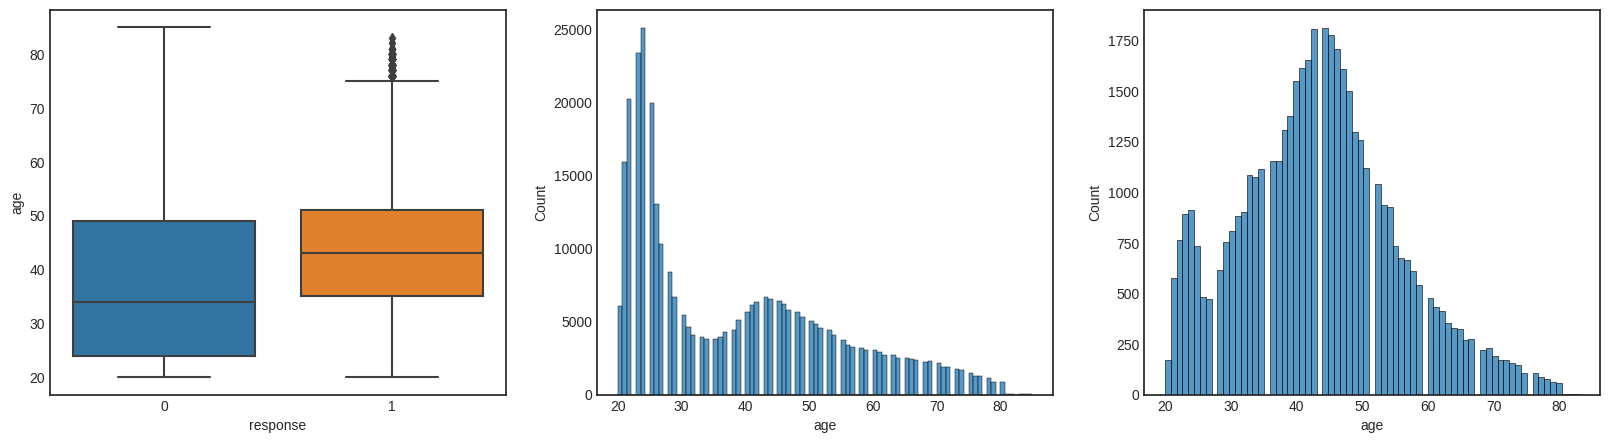

In [19]:
# age
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='age', data=df1)
sns.histplot(df1.loc[df1['response'] == 0, 'age'], ax=ax[1])
sns.histplot(df1.loc[df1['response'] == 1, 'age'], ax=ax[2])
#ax[1].hist(df1.loc[df1['response'] == 0, 'age'])

# A idade é representativa, porém o atributo response tem classes desbalanceadas

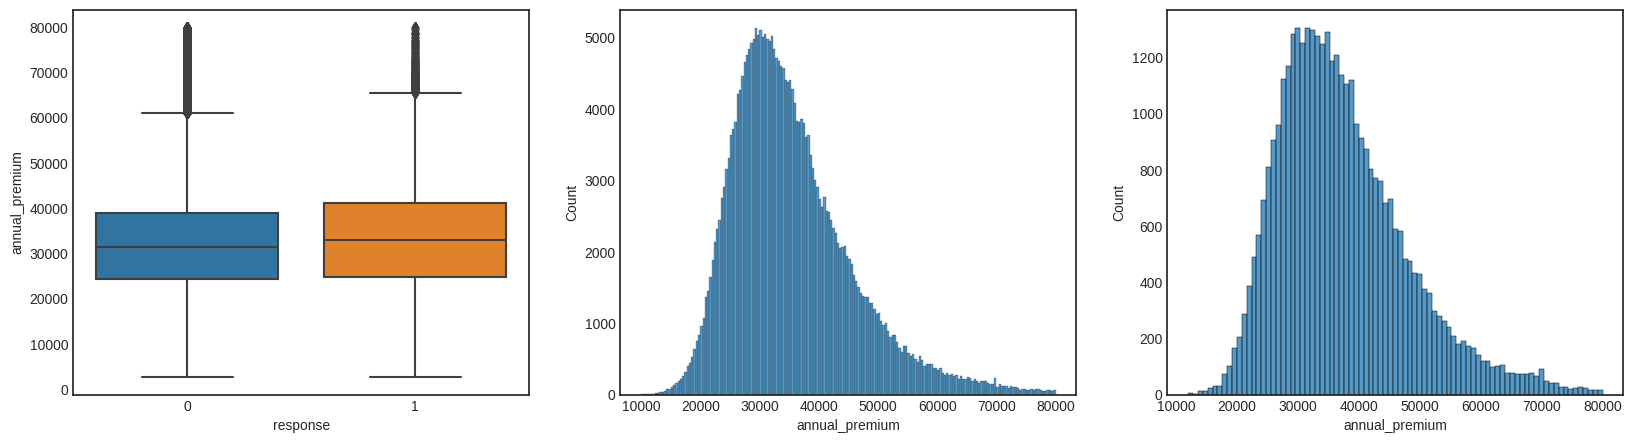

In [20]:
# annual_premium
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='annual_premium', data=df1.loc[df1['annual_premium'] < 80000])
sns.histplot(df1.loc[(df1['response'] == 0) & (df1['annual_premium'] > 10000) & (df1['annual_premium'] < 80000), 'annual_premium'], ax=ax[1])
sns.histplot(df1.loc[(df1['response'] == 1) & (df1['annual_premium'] > 10000) & (df1['annual_premium'] < 80000), 'annual_premium'], ax=ax[2]);

# Aparentemente não há distinção entre as classes de response quando se compara annual_premium

In [21]:
# driving_license
df1[['driving_license', 'response']].value_counts()

driving_license  response
1                0           333628
                 1            46669
0                0              771
                 1               41
Name: count, dtype: int64

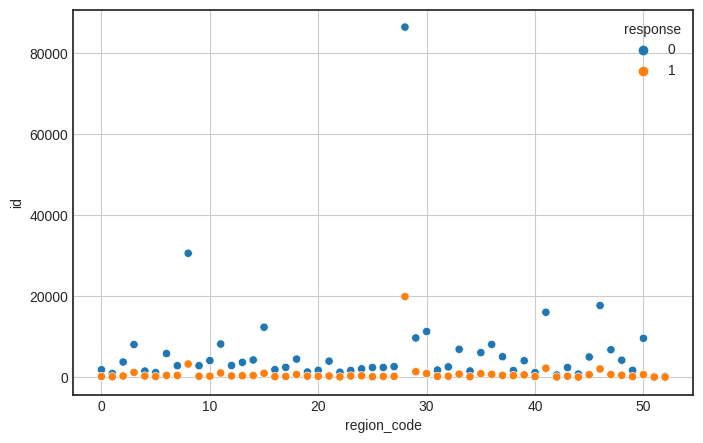

In [22]:
# region_code
aux = df1[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

plt.figure(figsize=(8,5))
sns.scatterplot(data=aux, x='region_code', y='id', hue='response')
plt.grid()

# region_code, aparentemente, não é capaz de explicar response

In [23]:
# previously_insured
pd.crosstab(df1['previously_insured'], df1['response'], normalize='index')      # normalizar pelo index retorna o percentual da coluna sobre o total de cada linha

# previously_insured praticamente replica a variável resposta. Não é bom para treinar o modelo

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [24]:
# vehicle_age
df1[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,proportion
0,below_1_year,0,0.413488
1,below_1_year,1,0.018897
2,between_1_2_years,0,0.434285
3,between_1_2_years,1,0.091328
4,over_2_years,0,0.029663
5,over_2_years,1,0.012338


In [25]:
# policy_sales_channel

aux = pd.crosstab(df1['policy_sales_channel'], df1['response'], normalize='index')

<Axes: xlabel='policy_sales_channel'>

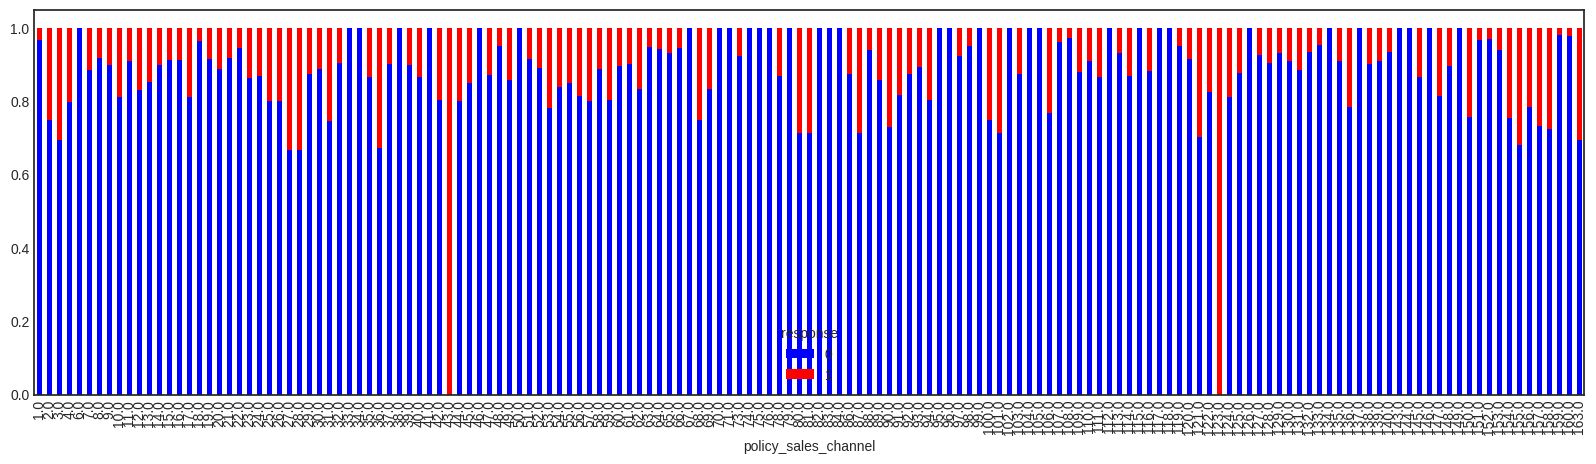

In [26]:
aux.plot(kind='bar', stacked=True, figsize=(20,5), colormap='bwr')

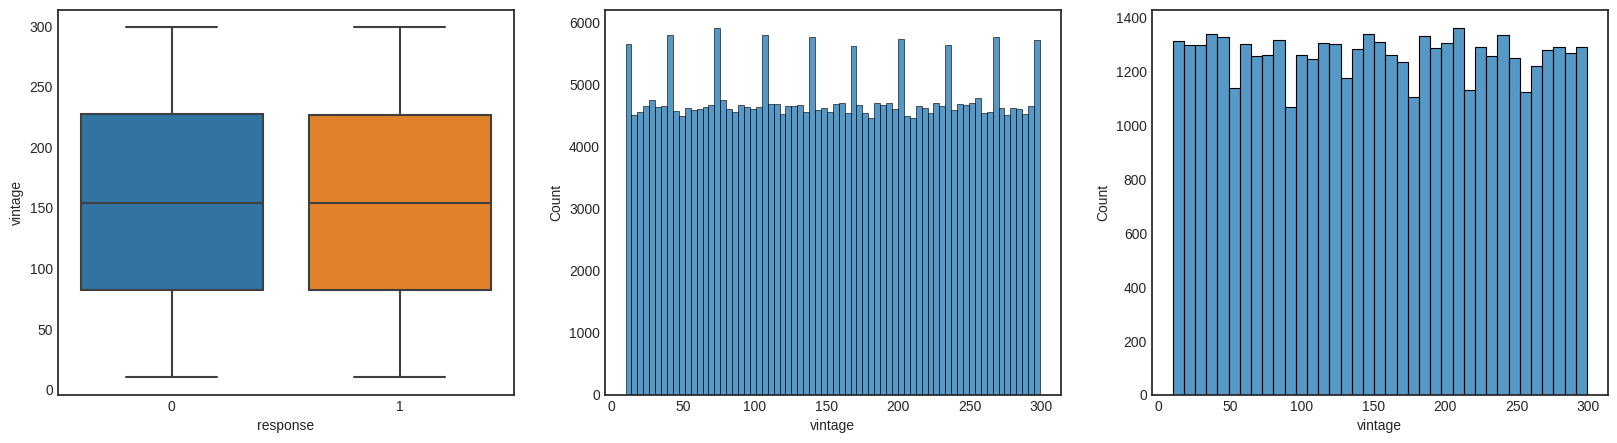

In [27]:
# vintage

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='vintage', data=df1)
sns.histplot(df1.loc[df1['response'] == 0, 'vintage'], ax=ax[1])
sns.histplot(df1.loc[df1['response'] == 1, 'vintage'], ax=ax[2]);

In [28]:
# gender

In [29]:
# vehicle_damage

# 5. Data Preparation

In [30]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


In [31]:
# Separando os dados entre treino (80%) e validação (20%)
df1_train, df1_val = train_test_split(df1, test_size=0.2, random_state=4, stratify=df1['response'])

X_val = df1_val.drop('response', axis=1)
y_val = df1_val['response']

save_interim(X_val, 'X_val.csv')
save_interim(y_val, 'y_val.csv')

In [32]:
df1_val.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
174913,174914,Female,66,1,8.0,1,between_1_2_years,0,35766.0,124.0,283,0
285991,285992,Female,31,1,41.0,1,below_1_year,0,32367.0,152.0,71,0
304875,304876,Female,40,1,30.0,1,between_1_2_years,0,30335.0,152.0,78,0
237743,237744,Male,28,1,50.0,1,below_1_year,0,30135.0,152.0,204,0
282070,282071,Female,45,1,33.0,0,between_1_2_years,1,2630.0,26.0,233,1


## 5.1. Standardization

- Ideal para dados que se aproximam de uma distribuição normal

In [33]:
# annual_premiuim
std_scaler = StandardScaler()

df1_train['annual_premium'] = std_scaler.fit_transform(df1_train[['annual_premium']])

In [34]:
pickle.dump(std_scaler, open('../models/annual_premium_feature.pkl', 'wb'))

## 5.2. Rescaling

- Quando os dados não apresentam distribuição normal

In [35]:
# age
mms_age = MinMaxScaler()
df1_train['age'] = mms_age.fit_transform(df1_train[['age']])

# vintage
mms_vintage = MinMaxScaler()
df1_train['vintage'] = mms_vintage.fit_transform(df1_train[['vintage']])

In [36]:
pickle.dump(mms_age, open('../models/age_feature.pkl', 'wb'))
pickle.dump(mms_vintage, open('../models/vintage_feature.pkl', 'wb'))

## 5.3. Encoder

In [37]:
# gender - target encoder
tar_enc_gender = TargetEncoder()
df1_train['gender'] = tar_enc_gender.fit_transform(df1_train[['gender']], df1_train['response'])

# region_code - target encoder
tar_enc_region_code = TargetEncoder()
df1_train['region_code'] = tar_enc_region_code.fit_transform(df1_train[['region_code']], df1_train['response'])

# vehicle_age - one hot encoder
ohe_vehicle_age = OneHotEncoder()
vehicle_age_encoded = ohe_vehicle_age.fit_transform(df1_train[['vehicle_age']])
vehicle_age_encoded = vehicle_age_encoded.toarray()
aux = pd.DataFrame(vehicle_age_encoded, columns=ohe_vehicle_age.get_feature_names_out(), index=df1_train.index)
df1_train = pd.concat([df1_train, aux], axis=1)
df1_train.drop('vehicle_age', axis=1, inplace=True)

# policy_sales_channel - frequency enconder
fe_policy_sales_channel = df1_train.groupby('policy_sales_channel').size() / len(df1_train)
df1_train.loc[:, 'policy_sales_channel'] = df1_train['policy_sales_channel'].map(fe_policy_sales_channel)

In [38]:
pickle.dump(tar_enc_gender, open('../models/gender_feature.pkl', 'wb'))
pickle.dump(tar_enc_region_code, open('../models/region_code_feature.pkl', 'wb'))
pickle.dump(ohe_vehicle_age, open('../models/vehicle_age_feature.pkl', 'wb'))
pickle.dump(fe_policy_sales_channel, open('../models/policy_sales_channel_feature.pkl', 'wb'))

In [39]:
save_interim(df1_train, 'train_df5.csv')

## 5.4. Validation Pipeline

In [40]:
# Fazer apenas transform

X_val['annual_premium'] = std_scaler.transform(X_val[['annual_premium']])

X_val['age'] = mms_age.transform(X_val[['age']])

X_val['vintage'] = mms_vintage.transform(X_val[['vintage']])

X_val['gender'] = tar_enc_gender.transform(X_val[['gender']])

X_val['region_code'] = tar_enc_region_code.transform(X_val[['region_code']])

X_val_vehicle_age_encoded = ohe_vehicle_age.transform(X_val[['vehicle_age']])
X_val_vehicle_age_encoded = X_val_vehicle_age_encoded.toarray()
aux = pd.DataFrame(X_val_vehicle_age_encoded, columns=ohe_vehicle_age.get_feature_names_out(), index=X_val.index)
X_val = pd.concat([X_val, aux], axis=1)
X_val.drop('vehicle_age', axis=1, inplace=True)

X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

In [41]:
X_val.isna().sum()

id                               0
gender                           0
age                              0
driving_license                  0
region_code                      0
previously_insured               0
vehicle_damage                   0
annual_premium                   0
policy_sales_channel             0
vintage                          0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_years    0
vehicle_age_over_2_years         0
dtype: int64

# 6. Feature Selection

<Axes: >

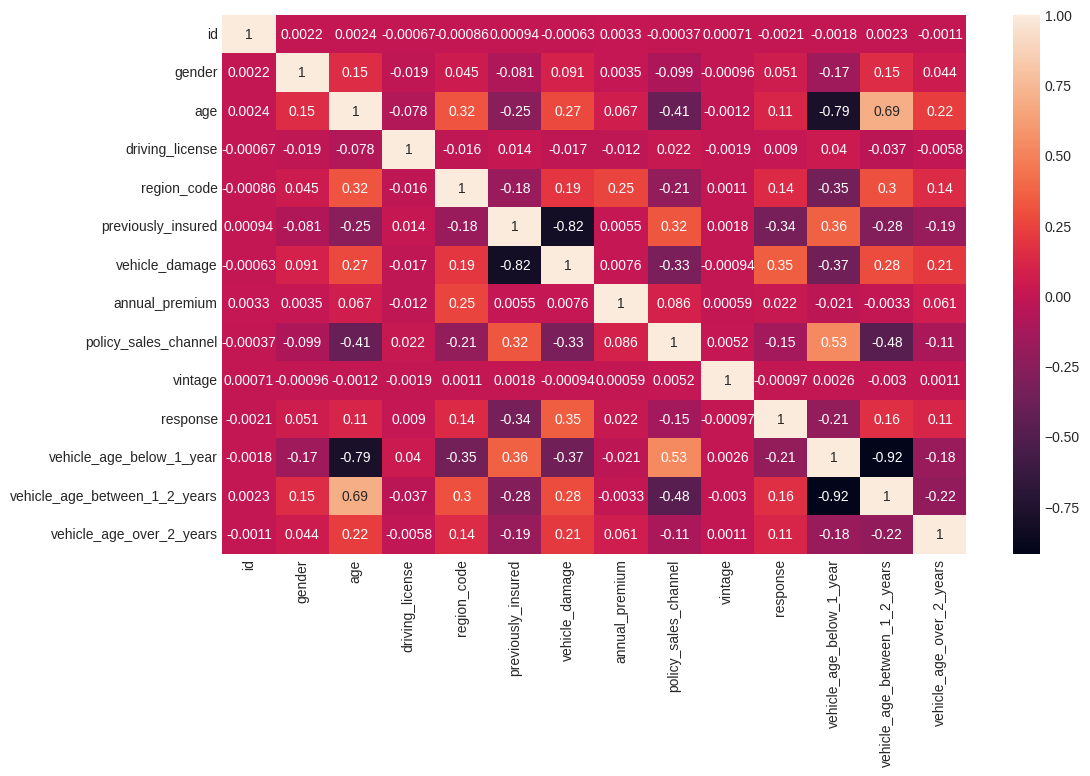

In [42]:
corr_matrix = df1_train.corr(method='pearson')

plt.figure(figsize=(12,7))
sns.heatmap(corr_matrix, annot=True)

## 6.1. Feature importance

- A partir de um modelo se busca encontrar as importâncias de cada feature para o dado modelo

In [43]:
# Treino do modelo
X_train_n = df1_train.drop(['id', 'response'], axis=1)
y_train_n = df1_train['response']

etree_clf = ExtraTreesClassifier(n_estimators=150, random_state=0, n_jobs=-1)
etree_clf.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=150, n_jobs=-1, random_state=0)

<Axes: title={'center': 'Feature Importance'}>

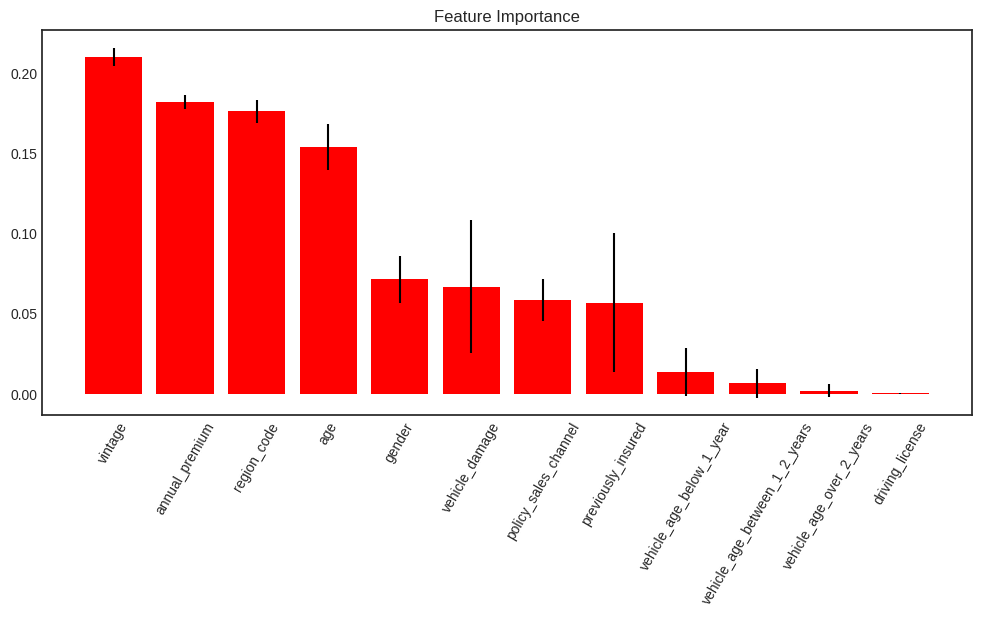

In [44]:
skplt.estimators.plot_feature_importances(etree_clf, feature_names=X_train_n.columns, figsize=(12,5), x_tick_rotation=60)

In [45]:
np.sort(etree_clf.feature_importances_)[::-1]

array([0.21006059, 0.18211885, 0.17624093, 0.15401702, 0.07153836,
       0.06703552, 0.05880247, 0.05706199, 0.01365221, 0.00676201,
       0.00224597, 0.00046408])

## 6.2. Boruta

In [46]:
#boruta_selector = BorutaPy(estimator=etree_clf, n_estimators='auto', verbose=2, random_state=42)
#boruta_selector.fit(X_train_n.values, y_train_n.values.ravel())

In [47]:
#X_train_n.loc[:, boruta_selector.support_]

# 7. Machine Learing

In [48]:
selected_features = ['vintage', 'annual_premium', 'region_code', 'age', 'gender', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# x_train = df1_train[selected_features]
# x_val = X_val[selected_features]

## 7.1. Teste com KNN

In [49]:
# Definição e treino do modelo
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(df1_train[selected_features], df1_train[['response']])

# Predição - poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(X_val[selected_features])

/home/ezequiel/.pyenv/versions/HICS/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

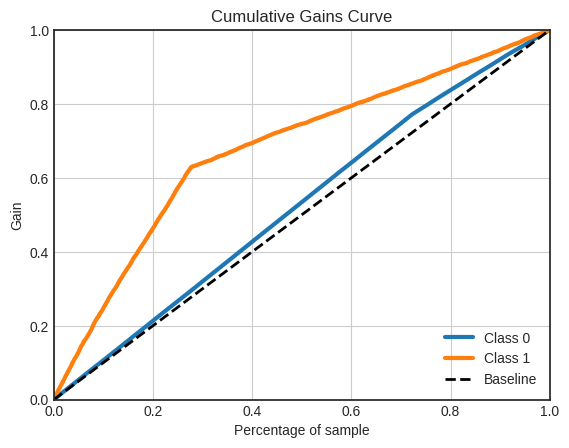

In [50]:
skplt.metrics.plot_cumulative_gain(y_true=y_val, y_probas=yhat_knn)
# Se 25% (Percentage of sample) das pessoas da lista ordenada forem abordadas, 63% (Gain) dos interessados serão aboradados
# Aumentando o n_neighbors, a curva pode melhorar

(0.5, 3.0)

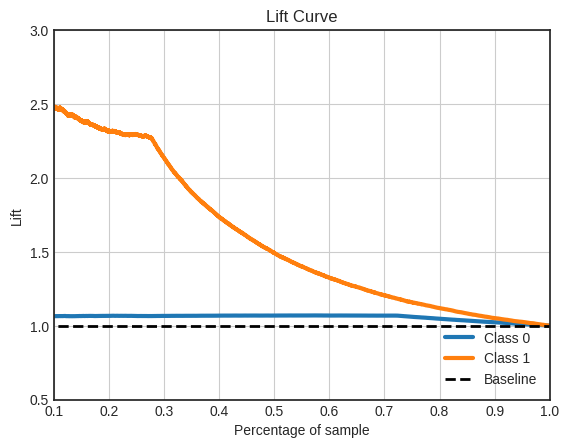

In [51]:
fig, ax = plt.subplots()
skplt.metrics.plot_lift_curve(y_true=y_val, y_probas=yhat_knn, ax=ax)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 3)

## 7.2 Teste com Logistic Regression

In [52]:
# Definição e treino do modelo
lr_model = LogisticRegression(random_state=42)
lr_model.fit(df1_train[selected_features], df1_train[['response']])

# Predição - poder de GENERALIZAÇÃO
yhat_lr = lr_model.predict_proba(X_val[selected_features])

/home/ezequiel/.pyenv/versions/HICS/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
yhat_lr[:,1]

array([0.00051824, 0.00056584, 0.00044184, ..., 0.28787679, 0.00092625,
       0.18382494])

In [54]:
pickle.dump(lr_model, open('/home/ezequiel/Documentos/Comunidade_DS/health_insurance_cross_sell/models/linear_regression_model.pkl', 'wb'))

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

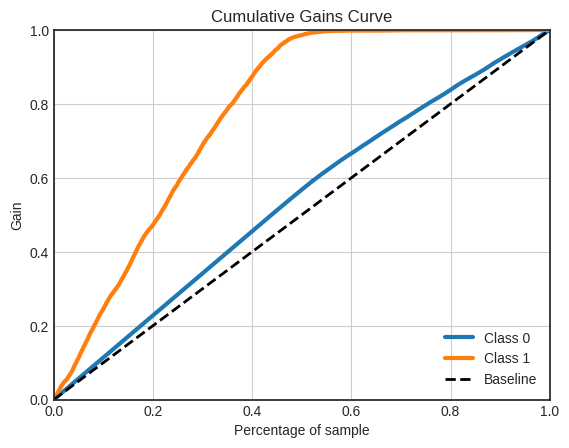

In [55]:
skplt.metrics.plot_cumulative_gain(y_true=y_val, y_probas=yhat_lr)
# Se 40% (Percentage of sample) das pessoas da lista ordenada forem abordadas, 90% (Gain) dos interessados serão aboradados

(0.5, 3.0)

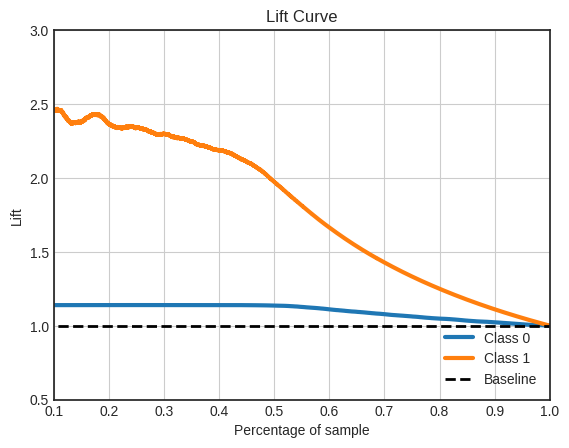

In [56]:
fig, ax = plt.subplots()
skplt.metrics.plot_lift_curve(y_true=y_val, y_probas=yhat_lr, ax=ax)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 3)

## 7.3. Metrics at K

In [57]:
# Propensity score
aux = pd.concat([X_val, y_val], axis=1)
aux['score'] = yhat_knn[:, 1].tolist()

# Sort clients by propensity score
aux = aux.sort_values('score', ascending=False)

aux = aux[['id', 'response', 'score']].reset_index(drop=True)

# K lines
K = 50

# Precision Top K
aux['precision_at_k'] = aux['response'].cumsum() / (aux.index.values + 1)
precision_at_k = aux.loc[K, 'precision_at_k']
print(f'Precision @ K: {precision_at_k:.6f}')

# Recall Top K
aux['recall_at_k'] = aux['response'].cumsum() / aux['response'].sum()
recall_at_k = aux.loc[K, 'recall_at_k']
print(f'Recall @ K: {recall_at_k:.6f}')

Precision @ K: 0.313725
Recall @ K: 0.001713
